In [1]:
import pandas as pd
import numpy as np
import random
import os
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')

# ======================
# 基本配置
# ======================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

DATA_FILE_PATH = r"G:\data\VWCModelData\LFMC-gridMean-ML-GaussianSmooth.xlsx"
# 修改保存文件夹，与之前不同
SAVE_DIR = r"G:\文章\HUITU\dmwjbc\spatial_split_dataset"
os.makedirs(SAVE_DIR, exist_ok=True)

# 非植被类型阈值配置
NON_VEGETATION_THRESHOLD = 0.05  # 5%


def load_and_preprocess_selected_data():
    """数据加载 + 清洗 + 特征工程（不划分）"""
    
    vod_columns = [
        'VOD_Ku_Hpol_Asc', 'VOD_Ku_Vpol_Asc',
        'VOD_X_Hpol_Asc', 'VOD_X_Vpol_Asc',
        'VOD_C_Hpol_Asc', 'VOD_C_Vpol_Asc'
    ]
    
    pft_columns = [
        'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne'
    ]
    
    feature_columns = vod_columns + ['LAI', 'Hveg'] + pft_columns
    
    # 添加空间坐标列
    required_columns = [
        'AGB', 'LFMCValue', 'SamplingDate',
        'LAI', 'Hveg', 'NoVegetation_PFT', 'RowVOD', 'ColVOD'
    ] + vod_columns + pft_columns
    
    df = pd.read_excel(DATA_FILE_PATH, usecols=required_columns)
    
    # 统一数值类型
    for col in df.columns:
        if col != 'SamplingDate':
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    df = df.dropna()
    
    print(f"初始样本数: {len(df)}")
    
    # # 过滤非植被占比≥5%的像元
    # df = df[df['NoVegetation_PFT'] < NON_VEGETATION_THRESHOLD]
    
    # print(f"过滤后样本数: {len(df)} (去除非植被占比≥{NON_VEGETATION_THRESHOLD*100}%的像元)")
    
    # 因变量
    df['VWC_sample'] = (df['AGB'] * df['LFMCValue']) / 1000
    df = df[df['VWC_sample'] <= 30]
    df = df[df['VWC_sample'] > 0]  # 保证因变量大于0
    
    print(f"VWC样本限制后样本数: {len(df)}")
    
    # 数值精度处理：保留6位小数
    for col in df.select_dtypes(include=[np.number]).columns:
        df[col] = df[col].round(6)
    
    return df, feature_columns


def split_by_spatial_independence(df, test_size=0.3, random_state=SEED):
    """按空间独立性划分训练集和验证集
    
    参数:
    - df: 包含空间坐标(RowVOD, ColVOD)的数据框
    - test_size: 验证集比例
    - random_state: 随机种子
    
    返回:
    - train_df: 训练集数据框
    - val_df: 验证集数据框
    """
    
    # 获取唯一的空间像元
    unique_pixels = df[['RowVOD', 'ColVOD']].drop_duplicates()
    unique_pixels = unique_pixels.reset_index(drop=True)
    
    print(f"唯一空间像元数: {len(unique_pixels)}")
    
    # 划分像元（确保训练集和验证集像元完全不重合）
    train_pixels, val_pixels = train_test_split(
        unique_pixels,
        test_size=test_size,
        random_state=random_state,
        shuffle=True
    )
    
    print(f"训练集像元数: {len(train_pixels)}")
    print(f"验证集像元数: {len(val_pixels)}")
    
    # 创建像元标识符
    df['pixel_id'] = df['RowVOD'].astype(str) + '_' + df['ColVOD'].astype(str)
    train_pixels['pixel_id'] = train_pixels['RowVOD'].astype(str) + '_' + train_pixels['ColVOD'].astype(str)
    val_pixels['pixel_id'] = val_pixels['RowVOD'].astype(str) + '_' + val_pixels['ColVOD'].astype(str)
    
    # 根据像元标识符划分数据
    train_df = df[df['pixel_id'].isin(train_pixels['pixel_id'].values)]
    val_df = df[df['pixel_id'].isin(val_pixels['pixel_id'].values)]
    
    # 删除临时列
    train_df = train_df.drop(columns=['pixel_id'])
    val_df = val_df.drop(columns=['pixel_id'])
    
    return train_df, val_df, train_pixels, val_pixels


def spatial_split_and_save():
    """按空间独立性划分训练/验证集，并保存"""
    
    # 加载数据
    df, feature_columns = load_and_preprocess_selected_data()
    
    # 按空间独立性划分
    train_df, val_df, train_pixels, val_pixels = split_by_spatial_independence(
        df, test_size=0.3, random_state=SEED
    )
    
    # 重置索引并保存原始索引
    train_df = train_df.reset_index(drop=True).copy()
    val_df = val_df.reset_index(drop=True).copy()
    
    train_original_index = train_df.index.values
    val_original_index = val_df.index.values
    
    # 将原始索引作为列添加到数据框中
    train_df.insert(0, 'original_index', train_original_index)
    val_df.insert(0, 'original_index', val_original_index)
    
    # 准备最终的特征数据集（不包含空间坐标和非植被比例等辅助列）
    final_features = feature_columns + ['VWC_sample']
    
    # 提取用于训练的特征集
    train_final = train_df[final_features + ['original_index']]
    val_final = val_df[final_features + ['original_index']]
    
    # 保存划分结果
    train_path = os.path.join(SAVE_DIR, "train_dataset.csv")
    val_path = os.path.join(SAVE_DIR, "val_dataset.csv")
    
    train_final.to_csv(train_path, index=False)
    val_final.to_csv(val_path, index=False)
    
    # 保存像元划分信息
    train_pixels_path = os.path.join(SAVE_DIR, "train_pixels.csv")
    val_pixels_path = os.path.join(SAVE_DIR, "val_pixels.csv")
    
    train_pixels.to_csv(train_pixels_path, index=False)
    val_pixels.to_csv(val_pixels_path, index=False)
    
    # 保存完整的原始数据（包含空间坐标等信息）
    train_full_path = os.path.join(SAVE_DIR, "train_full_dataset.csv")
    val_full_path = os.path.join(SAVE_DIR, "val_full_dataset.csv")
    
    train_df.to_csv(train_full_path, index=False)
    val_df.to_csv(val_full_path, index=False)
    
    print("\n数据划分完成")
    print(f"训练集样本数: {len(train_df)} (来自 {len(train_pixels)} 个唯一像元)")
    print(f"验证集样本数: {len(val_df)} (来自 {len(val_pixels)} 个唯一像元)")
    print(f"数据已保存至: {SAVE_DIR}")
    
    # 打印统计信息
    print(f"\n训练集统计:")
    print(f"- 空间像元数: {len(train_pixels)}")
    print(f"- 样本总数: {len(train_df)}")
    print(f"- VWC_sample均值: {train_df['VWC_sample'].mean():.2f}")
    print(f"- VWC_sample范围: [{train_df['VWC_sample'].min():.2f}, {train_df['VWC_sample'].max():.2f}]")
    
    print(f"\n验证集统计:")
    print(f"- 空间像元数: {len(val_pixels)}")
    print(f"- 样本总数: {len(val_df)}")
    print(f"- VWC_sample均值: {val_df['VWC_sample'].mean():.2f}")
    print(f"- VWC_sample范围: [{val_df['VWC_sample'].min():.2f}, {val_df['VWC_sample'].max():.2f}]")
    
    # 检查空间独立性
    train_pixel_set = set(zip(train_pixels['RowVOD'], train_pixels['ColVOD']))
    val_pixel_set = set(zip(val_pixels['RowVOD'], val_pixels['ColVOD']))
    
    overlap = train_pixel_set.intersection(val_pixel_set)
    print(f"\n空间独立性检查:")
    print(f"- 训练集和验证集重叠像元数: {len(overlap)}")
    if len(overlap) == 0:
        print("- ✅ 训练集和验证集空间像元完全独立")
    else:
        print("- ⚠️ 训练集和验证集存在空间重叠")


if __name__ == "__main__":
    spatial_split_and_save()

初始样本数: 21528
VWC样本限制后样本数: 21276
唯一空间像元数: 935
训练集像元数: 654
验证集像元数: 281

数据划分完成
训练集样本数: 15308 (来自 654 个唯一像元)
验证集样本数: 5968 (来自 281 个唯一像元)
数据已保存至: G:\文章\HUITU\dmwjbc\spatial_split_dataset

训练集统计:
- 空间像元数: 654
- 样本总数: 15308
- VWC_sample均值: 3.90
- VWC_sample范围: [0.00, 29.91]

验证集统计:
- 空间像元数: 281
- 样本总数: 5968
- VWC_sample均值: 3.93
- VWC_sample范围: [0.00, 29.77]

空间独立性检查:
- 训练集和验证集重叠像元数: 0
- ✅ 训练集和验证集空间像元完全独立


In [2]:
import pandas as pd
import numpy as np
import random
import os
import joblib
import warnings

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

import optuna
from optuna.samplers import TPESampler

warnings.filterwarnings("ignore")

# ======================
# 基本配置
# ======================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

DATA_DIR = r"G:\文章\HUITU\dmwjbc\spatial_split_dataset"
MODEL_SAVE_PATH = os.path.join(DATA_DIR, "RFR_6VOD_LAI_PFTs_Hveg.pkl")
IGBP_DATA_PATH = r"G:\data\VWCModelData\LFMC-gridMean-ML-GaussianSmooth.xlsx"
VAL_RESULT_SAVE_PATH = os.path.join(DATA_DIR, "val_prediction_with_IGBP_PFT.csv")

# ======================
# 读取已划分数据
# ======================
def load_train_val_dataset(data_dir):
    train_df = pd.read_csv(os.path.join(data_dir, "train_dataset.csv"))
    val_df = pd.read_csv(os.path.join(data_dir, "val_dataset.csv"))

    X_train = train_df.drop(columns=["VWC_sample", "original_index"])
    y_train = train_df["VWC_sample"]

    X_val = val_df.drop(columns=["VWC_sample", "original_index"])
    y_val = val_df["VWC_sample"]
    
    # 保留原始索引用于后续匹配
    val_indices = val_df["original_index"].values

    return X_train, X_val, y_train, y_val, val_indices, val_df


# ======================
# 贝叶斯优化目标函数
# ======================
def objective(trial, X, y):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 1000, step=100),
        "max_depth": trial.suggest_int("max_depth", 10, 50, step=10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 8),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
    }

    model = RandomForestRegressor(
        **params,
        random_state=SEED,
        n_jobs=-1
    )

    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    rmse_list = []

    for train_idx, val_idx in kf.split(X):
        X_tr, X_va = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_va = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_va)
        rmse_list.append(
            np.sqrt(mean_squared_error(y_va, y_pred))
        )

    return np.mean(rmse_list)


# ======================
# 保存验证集结果
# ======================
def save_validation_results(val_indices, y_pred, val_df):
    print("开始保存验证集预测结果...")
    
    # 读取含 IGBP 的原始数据
    full_df = pd.read_excel(IGBP_DATA_PATH)
    
    # 定义PFT列
    pft10_cols = [
        'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne'
    ]
    
    required_cols = (
        ["RowVOD", "ColVOD", "SamplingDate", "IGBP_MainType"] + pft10_cols
    )

    # 提取所需列
    sub_df = full_df.loc[val_indices, required_cols].reset_index(drop=True)

    # 计算Grass、Shrub、Tree列（通过10个PFT变量相加）
    sub_df["Grass"] = sub_df['Grass_man'] + sub_df['Grass_nat']
    sub_df["Shrub"] = sub_df['Shrub_bd'] + sub_df['Shrub_be'] + sub_df['Shrub_nd'] + sub_df['Shrub_ne']
    sub_df["Tree"] = sub_df['Tree_bd'] + sub_df['Tree_be'] + sub_df['Tree_nd'] + sub_df['Tree_ne']
    
    # 计算 PFT_MainType1（Grass / Shrub / Tree）
    sub_df["PFT_MainType1"] = (
        sub_df[["Grass", "Shrub", "Tree"]]
        .idxmax(axis=1)
    )
    
    # 计算 PFT_MainType2（10 个 PFT 中占比最大的）
    sub_df["PFT_MainType2"] = (
        sub_df[pft10_cols]
        .idxmax(axis=1)
    )
    
    # 构建最终结果表
    val_result_df = pd.DataFrame({
        "original_index": val_indices,
        "Satellite VWC": y_pred
    })
    
    val_result_df = pd.concat(
        [
            val_result_df,
            sub_df[[
                "RowVOD", "ColVOD", "SamplingDate",
                "IGBP_MainType",
                "PFT_MainType1", "PFT_MainType2"
            ]]
        ],
        axis=1
    )
    
    # 保存结果
    val_result_df.to_csv(VAL_RESULT_SAVE_PATH, index=False)
    
    print("验证集预测结果（含 PFT_MainType1 / PFT_MainType2）已保存")
    print(VAL_RESULT_SAVE_PATH)
    print(f"样本数: {len(val_result_df)}")
    
    return val_result_df

# ======================
# 主训练流程
# ======================
def train_and_validate():
    print("=" * 80)
    print("开始训练 Random Forest 模型（使用固定训练 / 验证集）")
    print("=" * 80)

    # 1. 读取数据
    X_train, X_val, y_train, y_val, val_indices, val_df = load_train_val_dataset(DATA_DIR)

    print(f"训练集样本数: {len(X_train)}")
    print(f"验证集样本数: {len(X_val)}")

    # 2. 贝叶斯优化
    print("\n开始贝叶斯优化调参...")
    study = optuna.create_study(
        direction="minimize",
        sampler=TPESampler(seed=SEED)
    )

    study.optimize(
        lambda trial: objective(trial, X_train, y_train),
        n_trials=10
    )

    best_params = study.best_params
    print("\n最优参数:")
    for k, v in best_params.items():
        print(f"{k}: {v}")
    print(f"交叉验证 RMSE: {study.best_value:.4f}")

    # 3. 使用最优参数训练最终模型
    print("\n训练最终模型...")
    final_model = RandomForestRegressor(
        **best_params,
        random_state=SEED,
        n_jobs=-1
    )
    final_model.fit(X_train, y_train)

    # 4. 验证集评估
    y_pred = final_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)

    print("\n验证集评估结果:")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2  : {r2:.4f}")

    # 5. 保存模型
    joblib.dump(final_model, MODEL_SAVE_PATH)
    print("\n模型已保存至:")
    print(MODEL_SAVE_PATH)
    
    # 6. 保存验证集结果
    print("\n" + "=" * 80)
    val_result_df = save_validation_results(val_indices, y_pred, val_df)
    
    return final_model, val_result_df


if __name__ == "__main__":
    model, val_results = train_and_validate()
    print("\n模型训练、验证与结果保存完成")

[I 2025-12-16 15:48:18,659] A new study created in memory with name: no-name-d92cc9f7-65bb-45a9-b920-69a3e1e0f493


开始训练 Random Forest 模型（使用固定训练 / 验证集）
训练集样本数: 15308
验证集样本数: 5968

开始贝叶斯优化调参...


[I 2025-12-16 15:48:29,851] Trial 0 finished with value: 1.7125503550646144 and parameters: {'n_estimators': 500, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.7125503550646144.
[I 2025-12-16 15:48:47,695] Trial 1 finished with value: 1.7066193898015733 and parameters: {'n_estimators': 700, 'max_depth': 40, 'max_features': 'log2', 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 1 with value: 1.7066193898015733.
[I 2025-12-16 15:49:01,093] Trial 2 finished with value: 1.7076386425742989 and parameters: {'n_estimators': 500, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 1 with value: 1.7066193898015733.
[I 2025-12-16 15:49:13,647] Trial 3 finished with value: 1.7255000338914832 and parameters: {'n_estimators': 600, 'max_depth': 40, 'max_features': 'log2', 'min_samples_split': 7, 'min_sam


最优参数:
n_estimators: 700
max_depth: 40
max_features: log2
min_samples_split: 9
min_samples_leaf: 2
bootstrap: False
交叉验证 RMSE: 1.7066

训练最终模型...

验证集评估结果:
RMSE: 2.4570
R2  : 0.7665

模型已保存至:
G:\文章\HUITU\dmwjbc\spatial_split_dataset\RFR_6VOD_LAI_PFTs_Hveg.pkl

开始保存验证集预测结果...
验证集预测结果（含 PFT_MainType1 / PFT_MainType2）已保存
G:\文章\HUITU\dmwjbc\spatial_split_dataset\val_prediction_with_IGBP_PFT.csv
样本数: 5968

模型训练、验证与结果保存完成


## 2 基于外部独立数据的精度验证

### 2.1 SMAP部分 (SMEX02、CLASIC07、SMAPVEX08、SMAPVEX12、SMAPVEX15、SMAPVEX16 Manitoba、SMAPVEX16 Iowa)

#### 2.1.1 前置处理部分

##### （1）分析上述数据集有没有和训练集产生完全的时空重合

##### （2）使用独立验证数据的0.1°地图结果，实现面（验证区域0.1°像元）对面（产品0.1°像元）之间的验证
    面-面：散点密度图

###### 1' 由于生产产品较慢，读取G:\data\VWC\test-VWC\的VWC_Map_results.xlsx，对表格进行合并，保存至总文件夹，最后使用各个产品进行机器学习的变量填充

xlsx文件的来源请参考Model_Article.ipynb的3.3 (1)-(7)

In [ ]:
import os
import numpy as np
import pandas as pd

# 需要处理的文件列表 
file_list = [
    r"G:\data\VWC\test-VWC\NSIDC_0666\SMEX02\VWC_Map_results.xlsx",  # SMEX02
    r"G:\data\VWC\test-VWC\Insitu CLASIC07\VWC_Map_results.xlsx",    # CLASIC07
    r"G:\data\VWC\test-VWC\Insitu SMAPVEX08\VWC_Map_results.xlsx",   # SMAPVEX08
    r"G:\data\VWC\test-VWC\SMAPVEX12\VWC_Map_results.xlsx",          # SMAPVEX12
    r"G:\data\VWC\test-VWC\SMAPVEX15\VWC_Map_results.xlsx",          # SMAPVEX15
    r"G:\data\VWC\test-VWC\Insitu SMAPVEX16 Manitoba\SMAPVEX16 Manitoba Map\VWC_Map_results.xlsx",  # SMAPVEX16 Manitoba
    r"G:\data\VWC\test-VWC\SMAPVEX16_Iowa\VWC_Map_results.xlsx"      # SMAPVEX16 Iowa
]

# 按你的要求命名各个 Sheet
sheet_names = [
    "SMEX02",
    "CLASIC07",
    "SMAPVEX08",
    "SMAPVEX12",
    "SMAPVEX15",
    "SMAPVEX16 Manitoba",
    "SMAPVEX16 Iowa"
]

# 输出文件路径
out_dir = r"G:\data\VWC\test-VWC\SMAP_PixelToPixel_Validation"
os.makedirs(out_dir, exist_ok=True)
out_file = os.path.join(out_dir, "VWC_Map_results.xlsx")

# 需要保留和重排的列
# 最终顺序会变成：Date, LonC, LatC, Row, Col, Map VWC
cols_base = ["Date", "LonC", "LatC", "Map VWC"]

def ensure_datetime_date(col: pd.Series) -> pd.Series:
    """
    确保 Date 列为 datetime 类型：
    - 若本来就是 datetime，直接返回；
    - 若是数字（int/float），视为 YYYYMMDD，转字符串再按 '%Y%m%d' 解析；
    - 若是字符串，直接按 '%Y%m%d' 解析。
    """
    # 已经是 datetime 类型
    if pd.api.types.is_datetime64_any_dtype(col):
        return col

    # 数字类型（包含 int/float）
    if np.issubdtype(col.dtype, np.number):
        # 先转为整数，再转字符串，保证 8 位（YYYYMMDD）
        s = col.astype("Int64").astype(str).str.zfill(8)
        return pd.to_datetime(s, format="%Y%m%d", errors="raise")

    # 其他情况当作字符串处理
    s = col.astype(str).str.strip()
    # 假定都是 8 位 YYYYMMDD
    return pd.to_datetime(s, format="%Y%m%d", errors="raise")


def compute_row_col(df: pd.DataFrame) -> pd.DataFrame:
    """
    根据 LatC / LonC 计算 0.1° 全球网格的行列号（1-based）：
    Lat: 89.95, 89.85, ..., -89.95   (共 1800)
    Lon: -179.95, -179.85, ..., 179.95 (共 3600)
    
    Row = round((89.95 - LatC) / 0.1) + 1
    Col = round((LonC - (-179.95)) / 0.1) + 1
    """
    # 确保经纬度为浮点数
    lat = pd.to_numeric(df["LatC"], errors="coerce")
    lon = pd.to_numeric(df["LonC"], errors="coerce")

    # 计算 Row（1-based）
    row = np.rint((89.95 - lat) / 0.1).astype("Int64") + 1
    # 计算 Col（1-based）
    col = np.rint((lon - (-179.95)) / 0.1).astype("Int64") + 1

    df["Row"] = row
    df["Col"] = col
    return df

# 写入到同一个 Excel 的不同 Sheet，mode="w" 保证每次运行都会覆盖旧文件
with pd.ExcelWriter(out_file, engine="openpyxl", mode="w") as writer:
    for path, sheet_name in zip(file_list, sheet_names):
        print(f"Reading: {path}")
        df = pd.read_excel(path)

        # 检查必要列是否齐全
        missing = [c for c in cols_base if c not in df.columns]
        if missing:
            raise ValueError(f"{path} 中缺少必要列: {missing}")

        # 只保留需要的 4 列
        sub = df[cols_base].copy()

        # 处理 Date 为 datetime
        sub["Date"] = ensure_datetime_date(sub["Date"])

        # 计算 Row / Col
        sub = compute_row_col(sub)

        # 调整列顺序：Date, LonC, LatC, Row, Col, Map VWC
        sub = sub[["Date", "LonC", "LatC", "Row", "Col", "Map VWC"]]

        # 保存到目标 Excel 的对应 Sheet
        sub.to_excel(writer, sheet_name=sheet_name, index=False)
        print(f"  -> 写入 sheet: {sheet_name}, 行数: {len(sub)}")

print(f"\n合并 & 重排 & 计算 Row/Col 后的结果已保存到: {out_file}")


###### 2' 制作一个副本，填充各个输入变量

In [ ]:
import os
from datetime import datetime, timedelta

import h5py
import numpy as np
import pandas as pd

# =========================
# 路径设置
# =========================

# 输入：原始像元对像元结果（已包含 Date/LonC/LatC/Row/Col/Map VWC）
RESULT_XLSX_IN = r"G:\data\VWC\test-VWC\SMAP_PixelToPixel_Validation\VWC_Map_results.xlsx"
# 输出：添加 VOD/LAI/LC/Hveg 后的新文件
RESULT_XLSX_OUT = r"G:\data\VWC\test-VWC\SMAP_PixelToPixel_Validation\VWC_Map_results_ML.xlsx"

# VOD 数据路径模板
VOD_AMSRE_TPL = r"G:\data\VOD\mat\kuxcVOD\ASC\MCCA_AMSRE_010D_CCXH_VSM_VOD_Asc_{ymd}_V0.nc4.mat"
VOD_AMSR2_TPL = r"G:\data\VOD\mat\kuxcVOD\ASC\MCCA_AMSR2_010D_CCXH_VSM_VOD_Asc_{ymd}_V0.nc4.mat"

# GLASS LAI 0.05° mat 文件模板（形如 2002-06-18.tif.mat）
GLASS_LAI_TPL = r"G:\data\GLASS LAI\005Degree\mat(2002-2024)\{date_str}.tif.mat"

# PFT 数据路径（年合成：YYYY.mat）
PFT_TPL = r"G:\data\ESACCI PFT\Resample\Data\{year}.mat"

# Hveg 数据路径
HVEG_FILE = r"G:\data\CanopyHeight\CH.mat"

# =========================
# 缓存（避免重复读同一文件）
# =========================
vod_cache = {}   # key: Timestamp(date) -> dict 或 None
lai_cache = {}   # key: Timestamp(date) -> 2D array 或 None
pft_cache = {}    # key: year -> dict(varname->2D array) 或 None
hveg_array = None  # 2D array，全局只加载一次

# =========================
# 通用 v7.3 读取函数
# =========================

def read_mat_v73(path, varname):
    """
    使用 h5py 读取 MATLAB v7.3 格式 .mat 文件中的变量 varname。
    返回 squeeze 后的 numpy 数组。
    如果是 (3600, 1800) 则自动转置为 (1800, 3600)（按全球0.1°网格假设）。
    """
    if not os.path.exists(path):
        raise FileNotFoundError(path)

    with h5py.File(path, "r") as f:
        if varname not in f:
            raise KeyError(f"{path} 中未找到变量 {varname}")
        dset = f[varname]
        arr = np.array(dset)
        arr = np.squeeze(arr)

    if arr.ndim == 2 and arr.shape == (3600, 1800):
        arr = arr.T

    return arr


# =========================
# VOD 读取与 QC
# =========================

def get_vod_arrays(date_obj):
    """
    给定日期，返回一个 dict:
      {
        'VOD_Ku_Hpol_Asc': 2D array,
        'VOD_X_Hpol_Asc': 2D array,
        'VOD_C_Hpol_Asc': 2D array,
        'VOD_Ku_Vpol_Asc': 2D array,
        'VOD_X_Vpol_Asc': 2D array,
        'VOD_C_Vpol_Asc': 2D array,
      }
    若文件不存在或读取失败，返回 None。
    """
    key = pd.Timestamp(date_obj).normalize()
    if key in vod_cache:
        return vod_cache[key]

    y = key.year
    ymd = key.strftime("%Y%m%d")
    if y < 2012:
        fpath = VOD_AMSRE_TPL.format(ymd=ymd)
    else:
        fpath = VOD_AMSR2_TPL.format(ymd=ymd)

    if not os.path.exists(fpath):
        vod_cache[key] = None
        return None

    try:
        QC = read_mat_v73(fpath, "QC").astype(np.int16)
    except Exception as e:
        print(f"[VOD] 读取失败 {fpath}: {e}")
        vod_cache[key] = None
        return None

    QC = np.squeeze(QC)

    def mask_var(var_name):
        arr = read_mat_v73(fpath, var_name).astype(float)
        arr[QC != 0] = np.nan
        return arr

    try:
        data = {
            "VOD_Ku_Hpol_Asc": mask_var("ku_vod_H"),
            "VOD_X_Hpol_Asc":  mask_var("x_vod_H"),
            "VOD_C_Hpol_Asc":  mask_var("c_vod_H"),
            "VOD_Ku_Vpol_Asc": mask_var("ku_vod_V"),
            "VOD_X_Vpol_Asc":  mask_var("x_vod_V"),
            "VOD_C_Vpol_Asc":  mask_var("c_vod_V"),
        }
    except Exception as e:
        print(f"[VOD] 读取 VOD 变量失败 {fpath}: {e}")
        vod_cache[key] = None
        return None

    vod_cache[key] = data
    return data


# =========================
# GLASS LAI：读取 & 插值
# =========================

def get_glass_composite_neighbors(date_obj):
    """
    根据 GLASS 8-day 合成规则，给定任意 date，
    返回 (prev_date, next_date) 两个 GLASS 中心日期。
    """
    year = date_obj.year
    doy = date_obj.timetuple().tm_yday
    # 合成日序列：1, 9, 17, 25, ...
    k = (doy - 1) // 8
    prev_doy = 1 + 8 * k
    prev_date = datetime(year, 1, 1) + timedelta(days=prev_doy - 1)

    next_doy = prev_doy + 8
    days_in_year = (datetime(year + 1, 1, 1) - datetime(year, 1, 1)).days
    if next_doy > days_in_year:
        next_date = None
    else:
        next_date = datetime(year, 1, 1) + timedelta(days=next_doy - 1)

    return prev_date, next_date


def load_lai_for_exact_date(date_obj):
    """
    尝试读取指定 YYYY-MM-DD 的 GLASS LAI 文件，成功返回 2D array，失败返回 None。
    """
    key = pd.Timestamp(date_obj).normalize()
    if key in lai_cache:
        return lai_cache[key]

    date_str = key.strftime("%Y-%m-%d")
    fpath = GLASS_LAI_TPL.format(date_str=date_str)
    if not os.path.exists(fpath):
        lai_cache[key] = None
        return None

    try:
        arr = read_mat_v73(fpath, "lai").astype(float)
    except Exception as e:
        print(f"[LAI] 读取失败 {fpath}: {e}")
        lai_cache[key] = None
        return None

    lai_cache[key] = arr
    return arr


def get_lai_array(date_obj):
    """
    返回给定日期的 LAI 2D 数组：
    - 若存在当日文件，直接返回；
    - 否则用前后 8 日合成文件做线性插值；
    - 若前/后文件也不存在，则尽力返回能读到的一侧，否则 None。
    """
    key = pd.Timestamp(date_obj).normalize()

    # 1. 当天
    arr = load_lai_for_exact_date(key)
    if arr is not None:
        return arr

    # 2. 插值
    prev_date, next_date = get_glass_composite_neighbors(key)
    arr_prev = load_lai_for_exact_date(prev_date) if prev_date is not None else None
    arr_next = load_lai_for_exact_date(next_date) if next_date is not None else None

    if (arr_prev is None) and (arr_next is None):
        return None
    if (arr_prev is not None) and (arr_next is None):
        return arr_prev
    if (arr_prev is None) and (arr_next is not None):
        return arr_next

    delta_total = (next_date - prev_date).days
    delta_cur = (key.to_pydatetime() - prev_date).days
    w = delta_cur / delta_total
    lai_interp = (1.0 - w) * arr_prev + w * arr_next
    return lai_interp


# =========================
# ESA CCI PFT 读取
# =========================

def get_pft_arrays(year):
    """
    读取该年的 PFT mat 文件，返回一个 dict: varname -> 2D array
    如 grassman, grassnat, ...
    若失败返回 None。
    """
    if year in pft_cache:
        return pft_cache[year]

    fpath = PFT_TPL.format(year=year)
    if not os.path.exists(fpath):
        pft_cache[year] = None
        return None

    pft_vars = [
        "grassman", "grassnat", "shrubbd", "shrubbe", "shrubnd", "shrubne", "treebd", "treebe", "treend", "treene",
    ]
    data = {}
    for v in pft_vars:
        try:
            arr = read_mat_v73(fpath, v).astype(float)
            data[v] = arr
        except Exception as e:
            print(f"[PFT] 读取 {fpath} 变量 {v} 失败: {e}")
            data[v] = None

    pft_cache[year] = data
    return data

# PFT 变量名到你之前使用的列名映射（主要是植被类）
PFT_NAME_MAP = {
    "grassman": "Grass_man",
    "grassnat": "Grass_nat",
    "shrubbd": "Shrub_bd",
    "shrubbe": "Shrub_be",
    "shrubnd":  "Shrub_nd",
    "shrubne": "Shrub_ne",
    "treebd": "Tree_bd",
    "treebe": "Tree_be",
    "treend": "Tree_nd",
    "treene": "Tree_ne",
}

# =========================
# Hveg 读取
# =========================

def get_hveg_array():
    """
    返回 2D Hveg 数组（只加载一次）。
    """
    global hveg_array
    if hveg_array is not None:
        return hveg_array

    if not os.path.exists(HVEG_FILE):
        print(f"[Hveg] 文件不存在: {HVEG_FILE}")
        hveg_array = None
        return None

    try:
        arr = read_mat_v73(HVEG_FILE, "Hveg").astype(float)
    except Exception as e:
        print(f"[Hveg] 读取失败 {HVEG_FILE}: {e}")
        hveg_array = None
        return None

    hveg_array = arr
    return hveg_array


# =========================
# 主流程
# =========================

def main():
    # 先尝试加载一次 Hveg（提前报错更清晰）
    _ = get_hveg_array()

    xls = pd.ExcelFile(RESULT_XLSX_IN)
    sheet_names = xls.sheet_names

    updated_sheets = {}

    for sheet in sheet_names:
        print(f"\n=== 处理 sheet: {sheet} ===")
        df = pd.read_excel(RESULT_XLSX_IN, sheet_name=sheet)

        needed_cols = ["Date", "Row", "Col", "Map VWC"]
        for c in needed_cols:
            if c not in df.columns:
                raise ValueError(f"sheet {sheet} 缺少必要列 {c}")

        # 确保 Date 为 datetime
        if not pd.api.types.is_datetime64_any_dtype(df["Date"]):
            df["Date"] = pd.to_datetime(df["Date"])

        # 初始化需要的新列
        vod_cols = [
            "VOD_Ku_Hpol_Asc", "VOD_X_Hpol_Asc", "VOD_C_Hpol_Asc",
            "VOD_Ku_Vpol_Asc", "VOD_X_Vpol_Asc", "VOD_C_Vpol_Asc"
        ]
        for c in vod_cols:
            if c not in df.columns:
                df[c] = np.nan

        if "LAI" not in df.columns:
            df["LAI"] = np.nan

        for short_name, full_name in PFT_NAME_MAP.items():
            if full_name not in df.columns:
                df[full_name] = np.nan

        if "Hveg" not in df.columns:
            df["Hveg"] = np.nan

        # 按日期分组处理
        grouped = df.groupby(df["Date"])
        for date_val, idx in grouped.groups.items():
            date_ts = pd.Timestamp(date_val)
            print(f"  处理日期: {date_ts.date()}, 行数: {len(idx)}")

            rows_0 = df.loc[idx, "Row"].astype(int).to_numpy() - 1
            cols_0 = df.loc[idx, "Col"].astype(int).to_numpy() - 1

            # --- VOD ---
            vod_data = get_vod_arrays(date_ts)
            if vod_data is not None:
                for col_name in vod_cols:
                    arr = vod_data[col_name]
                    vals = arr[rows_0, cols_0]
                    df.loc[idx, col_name] = vals

            # --- LAI ---
            lai_arr = get_lai_array(date_ts)
            if lai_arr is not None:
                lai_vals = lai_arr[rows_0, cols_0]
                df.loc[idx, "LAI"] = lai_vals

            # --- PFT ---
            year = date_ts.year
            pft_data = get_pft_arrays(year)
            if pft_data is not None:
                for short_name, full_name in PFT_NAME_MAP.items():
                    arr = pft_data.get(short_name, None)
                    if arr is None:
                        continue
                    vals = arr[rows_0, cols_0]
                    df.loc[idx, full_name] = vals

            # --- Hveg ---
            if hveg_array is not None:
                hvals = hveg_array[rows_0, cols_0]
                df.loc[idx, "Hveg"] = hvals

        updated_sheets[sheet] = df

    # 写到新文件 RESULT_XLSX_OUT（不会覆盖原始 VWC_Map_results.xlsx）
    with pd.ExcelWriter(RESULT_XLSX_OUT, engine="openpyxl", mode="w") as writer:
        for sheet, sdf in updated_sheets.items():
            sdf.to_excel(writer, sheet_name=sheet, index=False)
            print(f"写出 sheet: {sheet}, 行数: {len(sdf)}")

    print("\n所有 sheet 已更新并保存到新文件：")
    print(RESULT_XLSX_OUT)


if __name__ == "__main__":
    main()


###### 3' 从输入模型中获得结果（VWC RF）

In [3]:
import os
import numpy as np
import pandas as pd
import joblib

# =========================
# 路径设置
# =========================

# 含有 Date / LonC / LatC / Row / Col / Map VWC / VOD / LAI / PFT / Hveg 的表
INPUT_XLSX = r"G:\data\VWC\test-VWC\SMAP_PixelToPixel_Validation\VWC_Map_results_ML.xlsx"

# 训练好的：LAI + Hveg + LC + All VOD 的 RF 模型
MODEL_PATH = r"G:\文章\HUITU\dmwjbc\spatial_split_dataset\RFR_6VOD_LAI_PFTs_Hveg.pkl"

# 输出：带有 RF 估算 VWC 的新表
OUTPUT_XLSX = r"G:\data\VWC\test-VWC\SMAP_PixelToPixel_Validation\VWC_Pre.xlsx"

# 预测结果列名
PRED_COL = "VWC_RF_AllVOD"


def main():
    # =========================
    # 1. 加载模型 & 获取特征名
    # =========================
    if not os.path.exists(MODEL_PATH):
        raise FileNotFoundError(f"找不到模型文件: {MODEL_PATH}")

    rf_model = joblib.load(MODEL_PATH)
    print(f"模型已加载: {MODEL_PATH}")

    if not hasattr(rf_model, "feature_names_in_"):
        raise AttributeError(
            "模型没有 feature_names_in_ 属性，说明训练时没有使用带列名的 DataFrame。"
        )

    model_feats = list(rf_model.feature_names_in_)
    print("=== 模型训练时使用的特征名，共 {} 个 ===".format(len(model_feats)))
    for i, f in enumerate(model_feats, 1):
        print(f"{i:2d}. {f}")
    print("\n==========================================")

    # =========================
    # 2. 逐 sheet 读取 & 预测
    # =========================
    if not os.path.exists(INPUT_XLSX):
        raise FileNotFoundError(f"找不到输入文件: {INPUT_XLSX}")

    xls = pd.ExcelFile(INPUT_XLSX)
    sheet_names = xls.sheet_names
    print("待处理的 sheet:", sheet_names)

    out_sheets = {}

    for sheet in sheet_names:
        print(f"\n=== 处理 sheet: {sheet} ===")
        df = pd.read_excel(INPUT_XLSX, sheet_name=sheet)

        # 检查是否缺少模型所需的列
        df_cols_set = set(df.columns)
        model_set = set(model_feats)
        missing_in_df = model_set - df_cols_set

        if missing_in_df:
            print(f"  [警告] sheet {sheet} 缺少以下模型所需特征列，无法预测：")
            for c in sorted(missing_in_df):
                print("    *", c)
            # 直接保留原表数据，预测列全 NaN
            df[PRED_COL] = np.nan
            out_sheets[sheet] = df
            continue

        # 使用 reindex 按模型训练时的特征顺序取出列
        X_all = df.reindex(columns=model_feats)

        # 统计缺失值情况
        na_counts = X_all.isna().sum()
        print("  各特征缺失值统计：")
        for f in model_feats:
            print(f"    {f:40s}  缺失 {na_counts[f]:4d} 条")

        # 找到“所有特征都非 NaN”的行
        mask_valid = X_all.notna().all(axis=1)
        n_total = len(df)
        n_valid = mask_valid.sum()
        print(f"  总行数: {n_total}, 可用于预测的行数(所有特征非 NaN): {n_valid}")

        # 初始化预测结果列
        df[PRED_COL] = np.nan

        if n_valid > 0:
            X_valid = X_all.loc[mask_valid].astype(float)
            # 预测
            y_pred = rf_model.predict(X_valid)
            df.loc[mask_valid, PRED_COL] = y_pred
            print(f"  已对 {n_valid} 行进行了预测。")
        else:
            print("  [提示] 本 sheet 没有任何一行满足‘所有特征非 NaN’，不进行预测。")

        out_sheets[sheet] = df

    # =========================
    # 3. 保存到新的 Excel 文件
    # =========================
    out_dir = os.path.dirname(OUTPUT_XLSX)
    os.makedirs(out_dir, exist_ok=True)

    with pd.ExcelWriter(OUTPUT_XLSX, engine="openpyxl", mode="w") as writer:
        for sheet, sdf in out_sheets.items():
            sdf.to_excel(writer, sheet_name=sheet, index=False)
            print(f"写出 sheet: {sheet}, 行数: {len(sdf)}")

    print("\n全部完成，带 RF 估算 VWC 的结果已保存至：")
    print(OUTPUT_XLSX)


if __name__ == "__main__":
    main()


模型已加载: G:\文章\HUITU\dmwjbc\spatial_split_dataset\RFR_6VOD_LAI_PFTs_Hveg.pkl
=== 模型训练时使用的特征名，共 18 个 ===
 1. VOD_Ku_Hpol_Asc
 2. VOD_Ku_Vpol_Asc
 3. VOD_X_Hpol_Asc
 4. VOD_X_Vpol_Asc
 5. VOD_C_Hpol_Asc
 6. VOD_C_Vpol_Asc
 7. LAI
 8. Hveg
 9. Grass_man
10. Grass_nat
11. Shrub_bd
12. Shrub_be
13. Shrub_nd
14. Shrub_ne
15. Tree_bd
16. Tree_be
17. Tree_nd
18. Tree_ne

待处理的 sheet: ['SMEX02', 'CLASIC07', 'SMAPVEX08', 'SMAPVEX12', 'SMAPVEX15', 'SMAPVEX16 Manitoba', 'SMAPVEX16 Iowa']

=== 处理 sheet: SMEX02 ===
  各特征缺失值统计：
    VOD_Ku_Hpol_Asc                           缺失   32 条
    VOD_Ku_Vpol_Asc                           缺失   32 条
    VOD_X_Hpol_Asc                            缺失   32 条
    VOD_X_Vpol_Asc                            缺失   32 条
    VOD_C_Hpol_Asc                            缺失   32 条
    VOD_C_Vpol_Asc                            缺失   32 条
    LAI                                       缺失    0 条
    Hveg                                      缺失    0 条
    Grass_man                       

###### 4' 散点密度图结果

全局密度范围: [9.90e-04, 1.37e-01]
SMEX02:
  - 有效样本数: 0
  - 警告: 有效样本数不足2个，无法计算统计指标

CLASIC07:
  - 有效样本数: 6
  - 子图坐标轴范围: [0, 6]
  - 相关系数 (R) = -0.49, p = 3.29e-01 (not significant)
  - 决定系数 (R$^2$): -2.51
  - 均方根误差 (RMSE): 2.78 kg/m²

SMAPVEX08:
  - 有效样本数: 27
  - 子图坐标轴范围: [0, 6]
  - 相关系数 (R) = 0.14, p = 4.87e-01 (not significant)
  - 决定系数 (R$^2$): -36.94
  - 均方根误差 (RMSE): 3.24 kg/m²

SMAPVEX12:
  - 有效样本数: 1030
  - 子图坐标轴范围: [0, 16]
  - 相关系数 (R) = 0.25, p = 9.77e-16 (significant)
  - 决定系数 (R$^2$): -2.20
  - 均方根误差 (RMSE): 1.69 kg/m²

SMAPVEX15:
  - 有效样本数: 4
  - 子图坐标轴范围: [0, 5]
  - 相关系数 (R) = 0.83, p = 1.70e-01 (not significant)
  - 决定系数 (R$^2$): -1.59
  - 均方根误差 (RMSE): 2.80 kg/m²

SMAPVEX16 Manitoba:
  - 有效样本数: 88
  - 子图坐标轴范围: [0, 5]
  - 相关系数 (R) = 0.30, p = 5.06e-03 (significant)
  - 决定系数 (R$^2$): -3.33
  - 均方根误差 (RMSE): 1.79 kg/m²

SMAPVEX16 Iowa:
  - 有效样本数: 73
  - 子图坐标轴范围: [0, 6]
  - 相关系数 (R) = 0.61, p = 9.99e-09 (significant)
  - 决定系数 (R$^2$): -1.24
  - 均方根误差 (RMSE): 1.69 kg/m²

Summary 图已单独

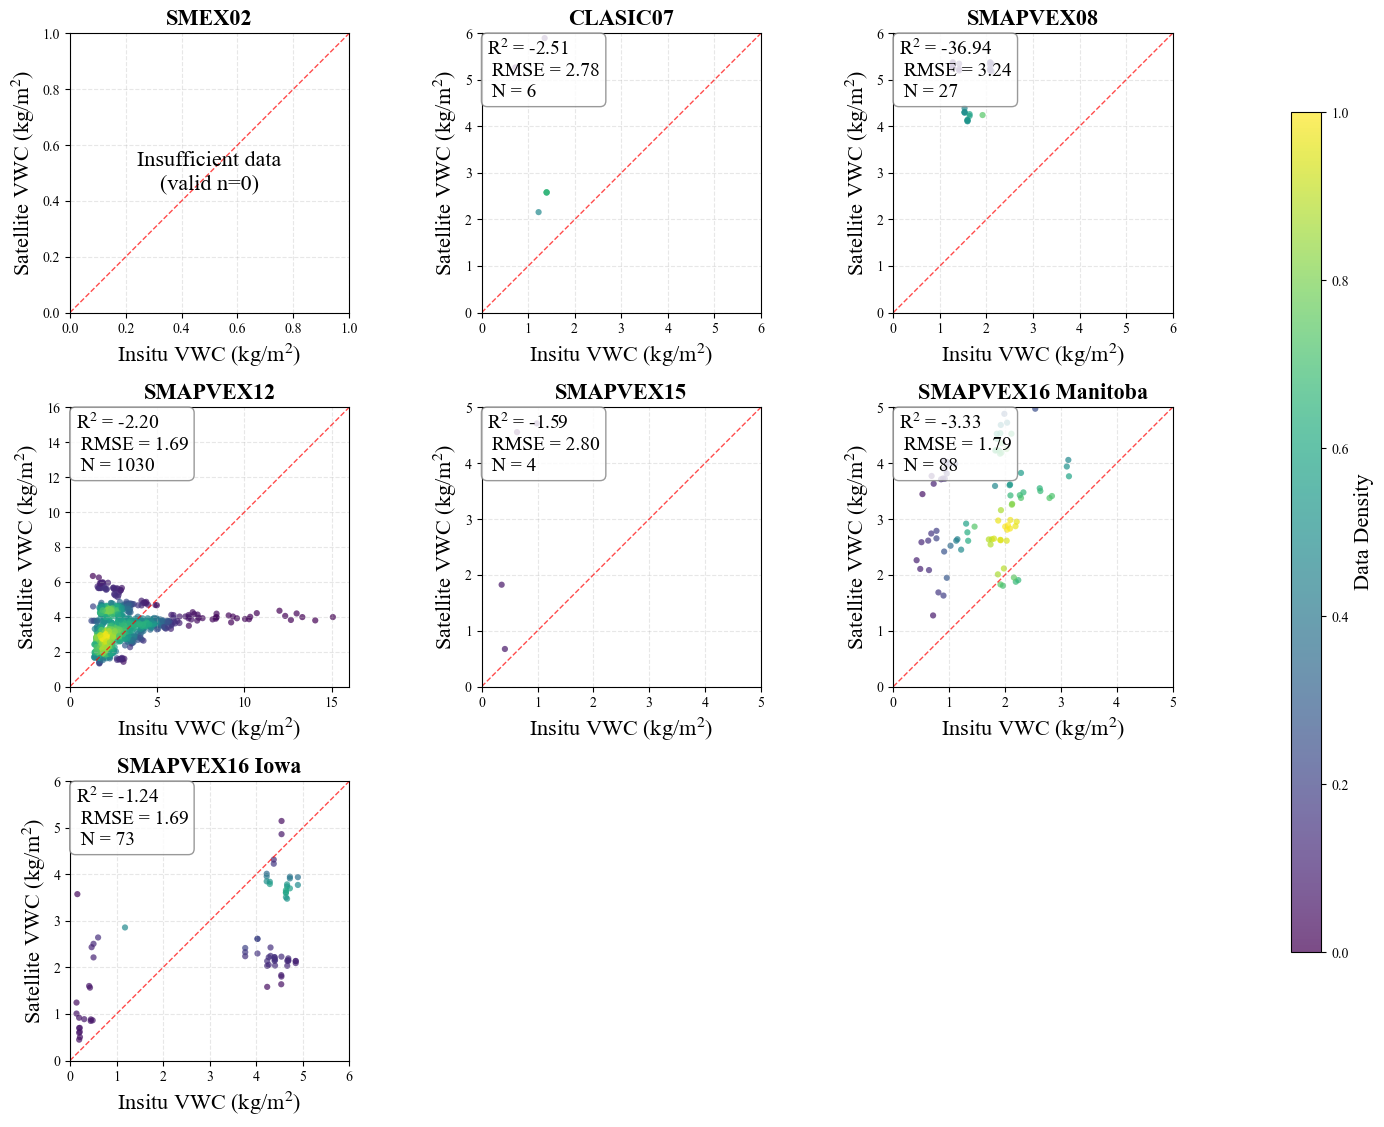

In [4]:
# save as plot_density_scatter.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.stats import pearsonr, gaussian_kde
from math import sqrt, ceil

# 设置全局字体为新罗马
rcParams['font.family'] = 'Times New Roman'
rcParams['mathtext.fontset'] = 'stix'  # 数学字体也使用Times New Roman风格

# 读取Excel文件
file_path = r"G:\data\VWC\test-VWC\SMAP_PixelToPixel_Validation\VWC_Pre.xlsx"

# 定义要处理的工作表名称
sheet_names = ['SMEX02', 'CLASIC07', 'SMAPVEX08', 'SMAPVEX12', 'SMAPVEX15', 'SMAPVEX16 Manitoba', 'SMAPVEX16 Iowa']

# 创建一个3x3的子图布局
fig, axes = plt.subplots(3, 3, figsize=(15, 12), dpi=100)
axes = axes.flatten()  # 将3x3的axes数组展平为1维，方便遍历

# 设置全局标题
fig.suptitle('', fontsize=16, fontweight='bold')

# 定义一个函数计算RMSE
def calculate_rmse(y_true, y_pred):
    """计算均方根误差"""
    # 确保输入是numpy数组
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # 移除NaN值
    mask = ~(np.isnan(y_true) | np.isnan(y_pred))
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    
    if len(y_true) == 0:
        return np.nan
    
    mse = np.mean((y_true - y_pred) ** 2)
    return sqrt(mse)

# 用于存储每个工作表的有效数据
all_worksheet_data = []

# 遍历每个工作表，收集有效数据
for sheet_name in sheet_names:
    # 读取当前工作表
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name)
    except Exception as e:
        print(f"读取工作表 '{sheet_name}' 时出错: {e}")
        all_worksheet_data.append((sheet_name, np.array([]), np.array([])))
        continue
    
    # 检查必需的列
    required_columns = ['Map VWC', 'VWC_RF_AllVOD']
    missing_cols = [col for col in required_columns if col not in df.columns]
    
    if missing_cols:
        print(f"工作表 '{sheet_name}' 缺少必需的列: {missing_cols}")
        all_worksheet_data.append((sheet_name, np.array([]), np.array([])))
        continue
    
    # 提取数据
    x = df['Map VWC'].values.astype(float)  # 转换为浮点数
    y = df['VWC_RF_AllVOD'].values.astype(float)  # 转换为浮点数
    
    # 创建有效数据掩码：排除NaN和-9999
    x_valid_mask = ~(np.isnan(x) | (np.abs(x + 9999) < 1e-6))
    y_valid_mask = ~(np.isnan(y) | (np.abs(y + 9999) < 1e-6))
    valid_mask = x_valid_mask & y_valid_mask
    x_valid = x[valid_mask]
    y_valid = y[valid_mask]
    
    # 存储数据
    all_worksheet_data.append((sheet_name, x_valid, y_valid))

# 收集所有有效数据用于统一的颜色映射
all_x_vals = []
all_y_vals = []

for sheet_name, x_valid, y_valid in all_worksheet_data:
    if len(x_valid) > 0 and len(y_valid) > 0:
        all_x_vals.extend(x_valid.tolist())
        all_y_vals.extend(y_valid.tolist())

# 计算密度估计用于颜色映射
if len(all_x_vals) > 0 and len(all_y_vals) > 0:
    all_x_vals = np.array(all_x_vals)
    all_y_vals = np.array(all_y_vals)
    
    # 使用高斯核密度估计
    xy = np.vstack([all_x_vals, all_y_vals])
    kde = gaussian_kde(xy)
    density = kde(xy)
    
    # 归一化密度
    density_norm = (density - density.min()) / (density.max() - density.min())
    
    # 计算密度值的范围用于颜色映射
    dmin, dmax = density.min(), density.max()
    print(f"全局密度范围: [{dmin:.2e}, {dmax:.2e}]")
else:
    density_norm = np.array([])
    dmin, dmax = 0, 1
    print("警告: 没有足够的数据计算密度")

# 用于存储有效的散点对象
valid_scatters = []

# 遍历每个工作表，绘制散点密度图
for idx, (sheet_name, x_valid, y_valid) in enumerate(all_worksheet_data):
    ax = axes[idx]
    
    # 计算有效样本数
    valid_count = len(x_valid)
    print(f"{sheet_name}:")
    print(f"  - 有效样本数: {valid_count}")
    
    # 计算统计指标
    if valid_count < 2:
        print(f"  - 警告: 有效样本数不足2个，无法计算统计指标")
        r_value_str = "N/A"
        r2_str = "N/A"
        rmse_str = "N/A"
    else:
        # 计算相关系数
        r_value, p_value = pearsonr(x_valid, y_valid)
        r_value_str = f"{r_value:.2f}"
        
        # 计算线性回归的决定系数 R²（不是 r²！）
        y_mean = np.mean(y_valid)
        ss_tot = np.sum((y_valid - y_mean)**2)
        ss_res = np.sum((y_valid - x_valid)**2)
        r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan
        r2_str = f"{r2:.2f}"
        
        # 计算RMSE
        rmse = calculate_rmse(x_valid, y_valid)
        rmse_str = f"{rmse:.2f}"
    
    # 绘制散点图
    if valid_count >= 2:
        # 计算当前工作表的密度
        if len(all_x_vals) > 0 and len(density_norm) > 0:
            # 为当前工作表的点计算密度
            xy_current = np.vstack([x_valid, y_valid])
            density_current = kde(xy_current)
            density_current_norm = (density_current - dmin) / (dmax - dmin)
        else:
            density_current_norm = np.ones(valid_count) * 0.5
        
        # 绘制圆形散点
        scatter = ax.scatter(x_valid, y_valid, c=density_current_norm, cmap='viridis', 
                            s=20, alpha=0.7, edgecolors='none', vmin=0, vmax=1)
        valid_scatters.append(scatter)  # 保存有效的散点对象
        
        # 在左上角添加统计信息
        stats_text = f"R$^2$ = {r2_str}\n RMSE = {rmse_str}\n N = {valid_count}"
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                fontsize=14, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray'))
        
        # 计算当前子图的数据范围
        x_min, x_max = np.min(x_valid), np.max(x_valid)
        y_min, y_max = np.min(y_valid), np.max(y_valid)
        
        # 计算绘图范围：取实测值和预测值的最大值，向上取整
        data_max = max(x_max, y_max)
        axis_max = ceil(data_max)
        axis_min = 0  # 从0开始
        
        # 如果axis_max小于1，设为1
        if axis_max < 1:
            axis_max = 1
        
        print(f"  - 子图坐标轴范围: [{axis_min}, {axis_max}]")
        
        # 绘制1:1参考线
        ax.plot([axis_min, axis_max], [axis_min, axis_max], 'r--', linewidth=1, alpha=0.7, label='1:1 line')
        
        # 设置坐标轴范围
        ax.set_xlim(axis_min, axis_max)
        ax.set_ylim(axis_min, axis_max)
        
        # 打印当前工作表的统计信息
        print(f"  - 相关系数 (R) = {r_value:.2f}, p = {p_value:.2e} ({'significant' if p_value<0.05 else 'not significant'})")
        print(f"  - 决定系数 (R$^2$): {r2_str}")
        print(f"  - 均方根误差 (RMSE): {rmse_str} kg/m²")
    else:
        # 创建空白子图
        ax.text(0.5, 0.5, f'Insufficient data\n(valid n={valid_count})', 
                ha='center', va='center', fontsize=16, transform=ax.transAxes)
        
        # 设置默认坐标轴范围
        axis_min, axis_max = 0, 1
        ax.set_xlim(axis_min, axis_max)
        ax.set_ylim(axis_min, axis_max)
        
        # 绘制1:1参考线
        ax.plot([axis_min, axis_max], [axis_min, axis_max], 'r--', linewidth=1, alpha=0.7, label='1:1 line')
    
    # 设置坐标轴标签
    ax.set_xlabel('Insitu VWC (kg/m$^2$)', fontsize=16)
    ax.set_ylabel('Satellite VWC (kg/m$^2$)', fontsize=16)
    
    # 设置子图标题
    ax.set_title(sheet_name, fontsize=16, fontweight='bold')
    
    # 添加网格
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # 确保坐标轴比例相同
    ax.set_aspect('equal', adjustable='box')
    
    print()

# === 新增 Summary 子图（第 3 行第 2 列，axes[8]） ===
summary_ax = axes[8]

if len(all_x_vals) >= 2:
    # 全数据统计量
    r_value, p_value = pearsonr(all_x_vals, all_y_vals)
    r_value_str = f"{r_value:.2f}"

    # R²（线性回归方式计算）
    y_mean = np.mean(all_y_vals)
    ss_tot = np.sum((all_y_vals - y_mean)**2)
    ss_res = np.sum((all_y_vals - all_x_vals)**2)
    r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan
    r2_str = f"{r2:.2f}"

    # RMSE
    rmse = calculate_rmse(all_x_vals, all_y_vals)
    rmse_str = f"{rmse:.2f}"

    # 散点密度（使用全局 KDE）
    xy_summary = np.vstack([all_x_vals, all_y_vals])
    density_summary = kde(xy_summary)
    density_summary_norm = (density_summary - dmin) / (dmax - dmin)

    # 绘制散点
    scatter = summary_ax.scatter(
        all_x_vals, all_y_vals,
        c=density_summary_norm, cmap='viridis',
        s=20, alpha=0.7, edgecolors='none',
        vmin=0, vmax=1
    )

    # 文本框
    stats_text = f"R$^2$ = {r2_str}\n RMSE = {rmse_str}\n N = {len(all_x_vals)}"
    summary_ax.text(0.02, 0.98, stats_text,
                    transform=summary_ax.transAxes,
                    fontsize=14, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white',
                              alpha=0.8, edgecolor='gray'))

    # 坐标轴范围
    x_min, x_max = np.min(all_x_vals), np.max(all_x_vals)
    y_min, y_max = np.min(all_y_vals), np.max(all_y_vals)
    axis_max = ceil(max(x_max, y_max))
    if axis_max < 1:
        axis_max = 1

    summary_ax.plot([0, axis_max], [0, axis_max],
                    'r--', linewidth=1, alpha=0.7)

    summary_ax.set_xlim(0, axis_max)
    summary_ax.set_ylim(0, axis_max)

else:
    summary_ax.text(0.5, 0.5, 'Insufficient data',
                    ha='center', va='center', fontsize=16)

# x/y 轴名称与其他图一致
summary_ax.set_xlabel('Insitu VWC (kg/m$^2$)', fontsize=16)
summary_ax.set_ylabel('Satellite VWC (kg/m$^2$)', fontsize=16)

summary_ax.set_title("Summary", fontsize=16, fontweight='bold')
summary_ax.grid(True, linestyle='--', alpha=0.3)
summary_ax.set_aspect('equal', adjustable='box')

# === 单独保存 Summary（总图）散点密度图 ===
fig_summary, ax_summary = plt.subplots(figsize=(6, 5), dpi=300)

if len(all_x_vals) >= 2:
    # 计算散点密度（沿用全局 KDE）
    xy_summary = np.vstack([all_x_vals, all_y_vals])
    density_summary = kde(xy_summary)
    density_summary_norm = (density_summary - dmin) / (dmax - dmin)

    # 绘制散点
    scatter_summary = ax_summary.scatter(
        all_x_vals, all_y_vals,
        c=density_summary_norm, cmap='viridis',
        s=20, alpha=0.7, edgecolors='none',
        vmin=0, vmax=1
    )

    # 统计指标
    r_value, p_value = pearsonr(all_x_vals, all_y_vals)
    r2 = 1 - np.sum((all_y_vals - all_x_vals)**2) / np.sum((all_y_vals - np.mean(all_y_vals))**2)
    rmse = calculate_rmse(all_x_vals, all_y_vals)

    stats_text = f"R$^2$ = {r2:.2f}\n RMSE = {rmse:.2f}\n N = {len(all_x_vals)}"
    ax_summary.text(0.02, 0.98, stats_text,
                    transform=ax_summary.transAxes,
                    fontsize=14, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white',
                              alpha=0.8, edgecolor='gray'))

    # 坐标轴范围
    axis_max = max(np.max(all_x_vals), np.max(all_y_vals))
    axis_max = ceil(axis_max) if axis_max >= 1 else 1
    ax_summary.plot([0, axis_max], [0, axis_max],
                    'r--', linewidth=1, alpha=0.7)
    ax_summary.set_xlim(0, axis_max)
    ax_summary.set_ylim(0, axis_max)
else:
    ax_summary.text(0.5, 0.5, "Insufficient data",
                    ha='center', va='center', fontsize=16)

# 标签与标题
ax_summary.set_xlabel('Insitu VWC (kg/m$^2$)', fontsize=16)
ax_summary.set_ylabel('Satellite VWC (kg/m$^2$)', fontsize=16)
ax_summary.set_title('Summary', fontsize=18, fontweight='bold')
ax_summary.grid(True, linestyle='--', alpha=0.3)
ax_summary.set_aspect('equal', adjustable='box')

# 添加颜色条
cbar = fig_summary.colorbar(scatter_summary)
cbar.set_label('Data Density', fontsize=14)

# 保存独立 Summary 图
output_summary_path = r"G:\文章\HUITU\Fig\Pixeltopixel\VWC_Summary_ScatterDensity.png"
fig_summary.savefig(output_summary_path, dpi=300, bbox_inches='tight')
print(f"Summary 图已单独保存到: {output_summary_path}")

plt.close(fig_summary)

# 隐藏多余的空子图
for idx in range(len(sheet_names), len(axes)):
    axes[idx].set_visible(False)

# 调整子图布局
if valid_scatters:  # 如果有有效的散点对象
    plt.tight_layout(rect=[0, 0, 0.85, 0.96])  # 为全局标题和颜色条留出空间
    
    # 创建颜色条轴
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [左, 下, 宽, 高]
    cb = fig.colorbar(valid_scatters[0], cax=cbar_ax)  # 使用第一个有效的散点对象
    cb.set_label('Data Density', fontsize=16)
else:
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # 没有颜色条，使用完整宽度

# 保存图形（可选）
output_fig_path = r"G:\文章\HUITU\Fig\Pixeltopixel\VWC_Map_align_ScatterDensity.png"
plt.savefig(output_fig_path, dpi=300, bbox_inches='tight')
print(f"\n图形已保存到: {output_fig_path}")

# 显示图形
plt.show()